# Computing centralities from OSM data


Install and update `cityseer` if necessary.


In [1]:
# !pip install --upgrade cityseer

See the [guide](https://cityseer.benchmarkurbanism.com/guide) for a preamble.

Please also see the [`graph cleaning`](https://cityseer.benchmarkurbanism.com/guide#graph-cleaning) guide for additional information on the graph cleaning approach.

This notebook uses OSM data to compare three strategies for network preparation and then compares the centralities computed on each:

1. Algorithmically cleaning and consolidating the network
2. Using a minimally cleaned network which strips out unnecessary nodes but doesn't apply any consolidation methods.
3. Using a minimally cleaned network but with corrections for network distortions through edge "dissolving" and "jitter".

### Preparing the data extents


In [2]:
import matplotlib.pyplot as plt
from cityseer import rustalgos
from cityseer.metrics import networks
from cityseer.tools import graphs, io, plot

# download from OSM
lng, lat = -0.13396079424572427, 51.51371088849723
buffer = 5000
distances = [250, 500, 1000, 2000]
# creates a WGS shapely polygon
poly_wgs, poly_utm, _utm_zone_number, _utm_zone_letter = io.buffered_point_poly(lng, lat, buffer)

INFO:cityseer.tools.io:UTM conversion info: UTM zone number: 30, UTM zone letter: U


### Automatic cleaning

This approach prepares a network using automated algorithmic cleaning methods to consolidate complex intersections and parallel roads.


In [3]:
G_utm = io.osm_graph_from_poly(poly_wgs, simplify=True, remove_parallel=True, iron_edges=False)
# decompose for higher resolution analysis
G_decomp = graphs.nx_decompose(G_utm, 25)
# prepare data structures
nodes_gdf, _edges_gdf, network_structure = io.network_structure_from_nx(G_decomp, crs=32629)
# compute centralities
# if computing wider area centralities, e.g. 20km, then use less decomposition to speed up the computation
nodes_gdf = networks.node_centrality_shortest(
    network_structure=network_structure,
    nodes_gdf=nodes_gdf,
    distances=distances,
)

INFO:cityseer.tools.io:Converting networkX graph from EPSG code 4326 to EPSG code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
100%|██████████| 152922/152922 [00:00<00:00, 445846.74it/s]
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
100%|██████████| 166367/166367 [00:00<00:00, 961714.08it/s]
INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|██████████| 166367/166367 [00:05<00:00, 32864.31it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 152922/152922 [00:19<00:00, 7700.38it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 43126/43126 [00:00<00:00, 288622.63it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 40284/40284 [00:00<00:00, 67498.32it/s]
INFO:cityseer.tools.util:Creating nodes STR tree
100%|██████████| 38260/38260 [00:00<00:00, 105055.57it/s]
INFO:cityseer.tools.graphs:Consolidating nodes.
100%|██████████| 38260/38260 [00:17<00:00, 2241.55it/s]
IN

### Minimal cleaning

This method performs minimal cleaning and is used for reference point for the other two methods.


In [4]:
# generate OSM graph from polygon - note no automatic simplification applied
G_utm_minimal = io.osm_graph_from_poly(poly_wgs, simplify=False)
# do minimal graph cleaning
G_utm_minimal = graphs.nx_simple_geoms(G_utm_minimal)
G_utm_minimal = graphs.nx_remove_filler_nodes(G_utm_minimal)
G_utm_minimal = graphs.nx_remove_dangling_nodes(G_utm_minimal, despine=15)
# decompose for higher resolution analysis
G_decomp_minimal = graphs.nx_decompose(G_utm_minimal, 25)
# prepare data structures
nodes_gdf_minimal, _edges_gdf_minimal, network_structure_minimal = io.network_structure_from_nx(
    G_decomp_minimal, crs=32629
)
# compute centrality
nodes_gdf_minimal = networks.node_centrality_shortest(
    network_structure=network_structure_minimal,
    nodes_gdf=nodes_gdf_minimal,
    distances=distances,
)

INFO:cityseer.tools.io:Converting networkX graph from EPSG code 4326 to EPSG code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
100%|██████████| 152922/152922 [00:00<00:00, 468457.93it/s]
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
100%|██████████| 166367/166367 [00:00<00:00, 898009.48it/s]
INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|██████████| 166367/166367 [00:05<00:00, 31753.26it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 152922/152922 [00:21<00:00, 7006.55it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 43126/43126 [00:00<00:00, 270997.56it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 40284/40284 [00:00<00:00, 63867.02it/s]
INFO:cityseer.tools.graphs:Decomposing graph to maximum edge lengths of 25.
100%|██████████| 53474/53474 [00:24<00:00, 2165.71it/s]
INFO:cityseer.tools.io:Preparing node and edge arrays from networkX graph.
100%|█

### Dissolving network weights

This approach doesn't attempt to consolidate the network. Instead, it uses techniques to control for messy network representations:

- It "dissolves" network weights - meaning that nodes representing street segments which are likely duplicitous are weighted less heavily.
- It injects "jitter" to derive more intuitively consistent network routes.


In [5]:
# generate dissolved weights
G_dissolved_wts = graphs.nx_weight_by_dissolved_edges(G_decomp_minimal, 15)
# prepare data structures
nodes_gdf_dissolved, _edges_gdf_dissolved, network_structure_dissolved = io.network_structure_from_nx(
    G_dissolved_wts, crs=32629
)
# compute centralities
nodes_gdf_dissolved = networks.node_centrality_shortest(
    network_structure=network_structure_dissolved,
    nodes_gdf=nodes_gdf_dissolved,
    distances=distances,
    jitter_scale=20,
)

INFO:cityseer.tools.graphs:Generating node weights based on locally dissolved edges using a buffer of 15m.
INFO:cityseer.tools.util:Creating edges STR tree.
100%|██████████| 110120/110120 [00:04<00:00, 27374.74it/s]
INFO:cityseer.tools.io:Preparing node and edge arrays from networkX graph.
100%|██████████| 110120/110120 [00:21<00:00, 5101.87it/s]
INFO:cityseer.metrics.networks:Computing shortest path node centrality.
100%|██████████| 110120/110120 [05:33<00:00, 329.76it/s]


### Plots

Compares a selection of distance thresholds for each approach.



    "Gravity" index (spatial impedance weighted closeness-like centrality):
    Avg walking tolerance: 87.80m
    Beta: 0.016 (spatial impedance factor)
    Max walking tolerance: 250.0m
    


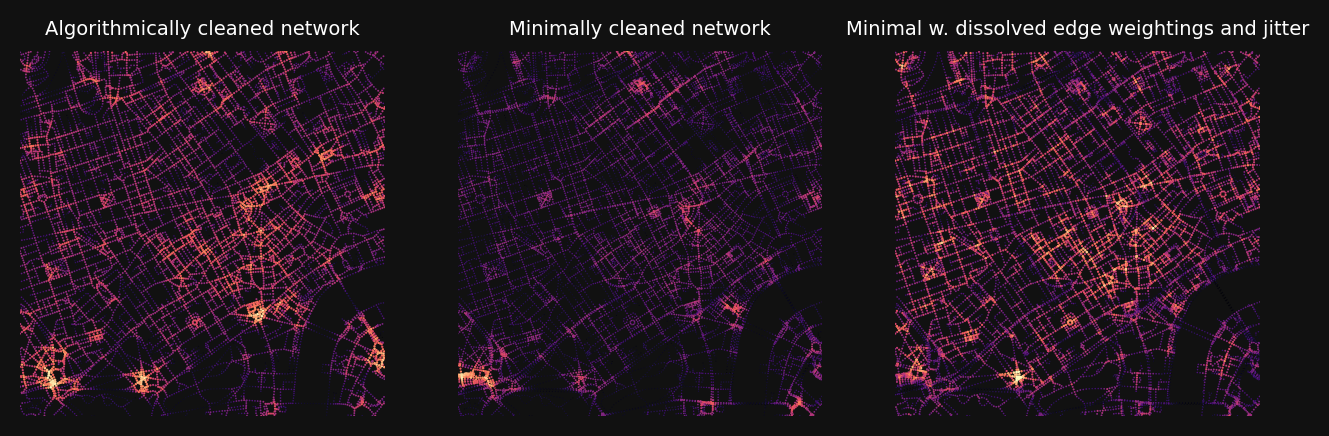


    "Gravity" index (spatial impedance weighted closeness-like centrality):
    Avg walking tolerance: 175.60m
    Beta: 0.008 (spatial impedance factor)
    Max walking tolerance: 500.0m
    


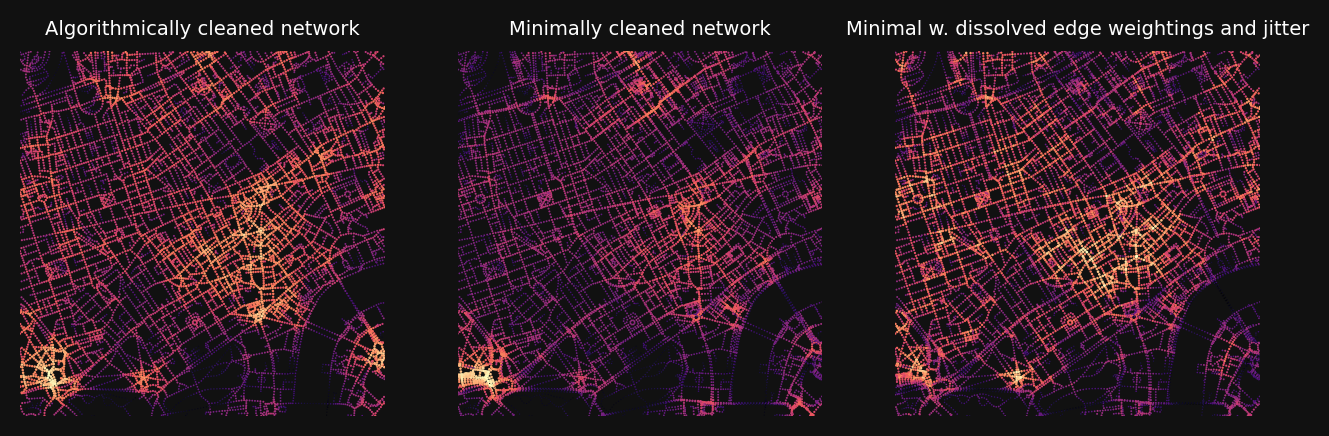


    "Gravity" index (spatial impedance weighted closeness-like centrality):
    Avg walking tolerance: 351.19m
    Beta: 0.004 (spatial impedance factor)
    Max walking tolerance: 1000.0m
    


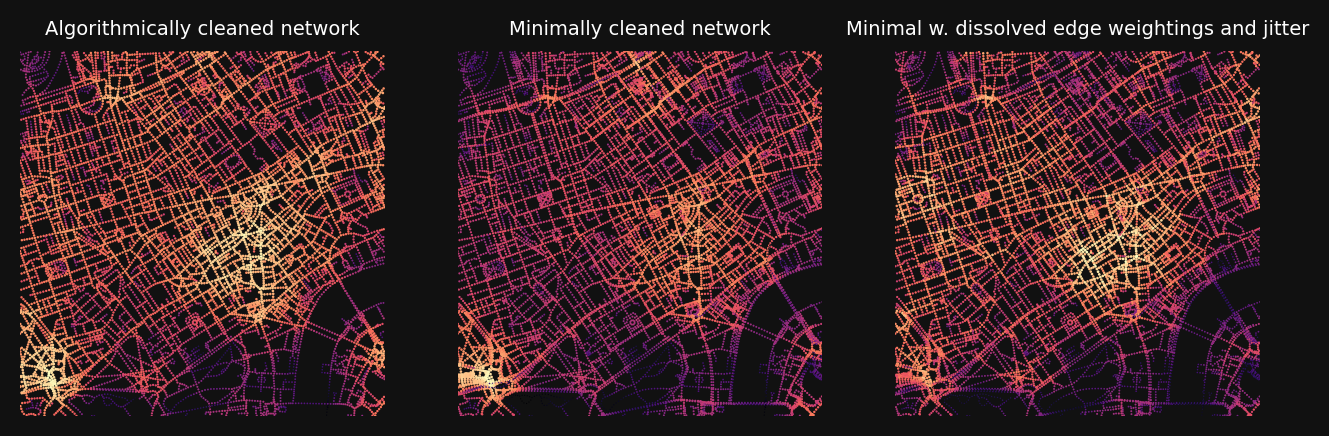


    "Gravity" index (spatial impedance weighted closeness-like centrality):
    Avg walking tolerance: 702.39m
    Beta: 0.002 (spatial impedance factor)
    Max walking tolerance: 2000.0m
    


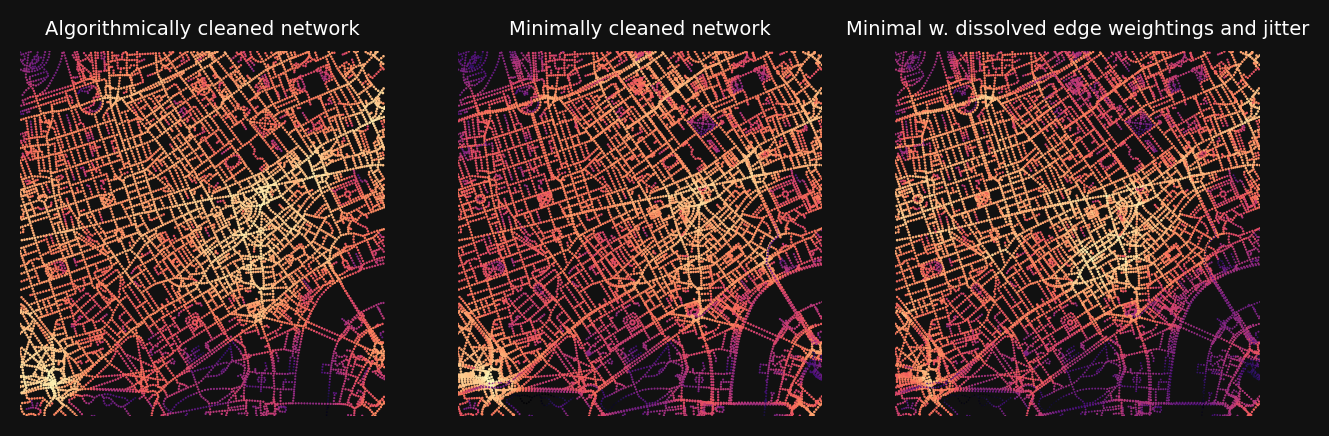


    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: 87.80m
    Beta: 0.016 (spatial impedance factor)
    Max walking tolerance: 250.0m
    


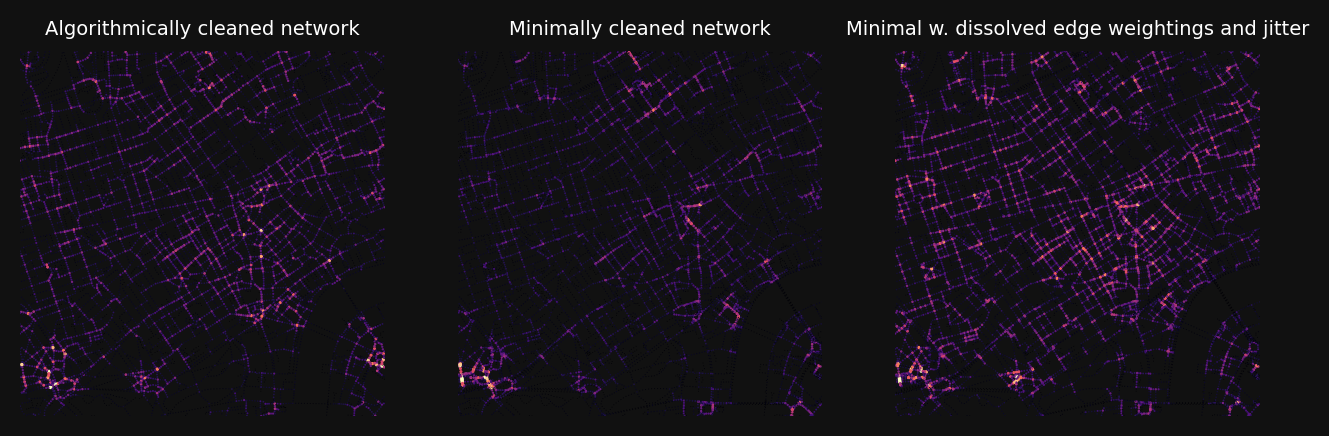


    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: 175.60m
    Beta: 0.008 (spatial impedance factor)
    Max walking tolerance: 500.0m
    


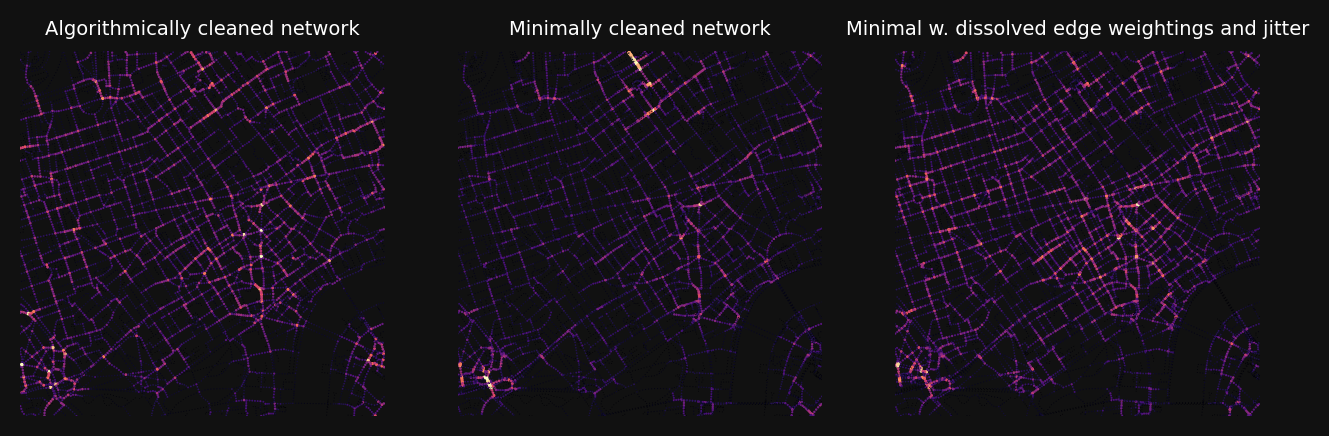


    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: 351.19m
    Beta: 0.004 (spatial impedance factor)
    Max walking tolerance: 1000.0m
    


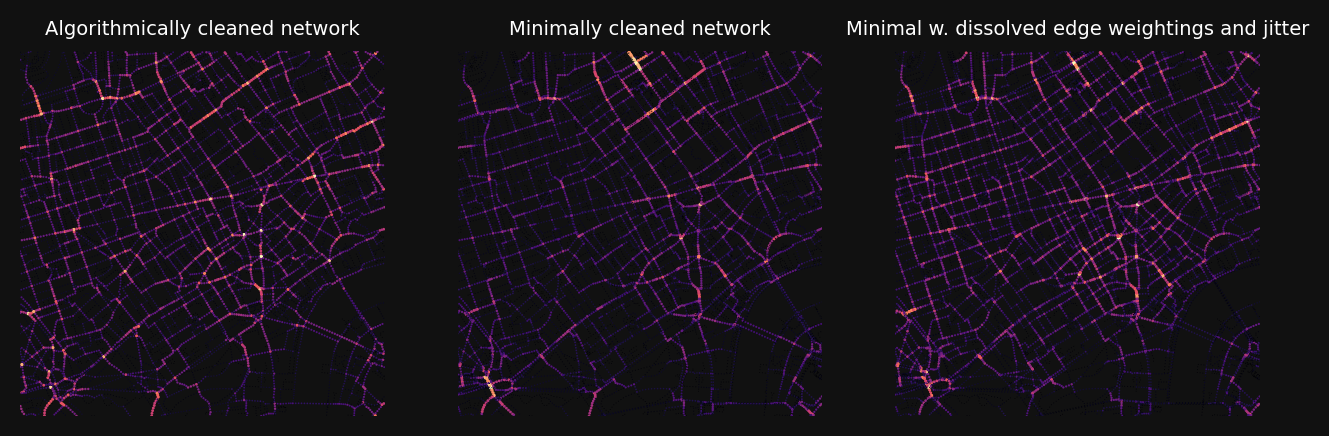


    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: 702.39m
    Beta: 0.002 (spatial impedance factor)
    Max walking tolerance: 2000.0m
    


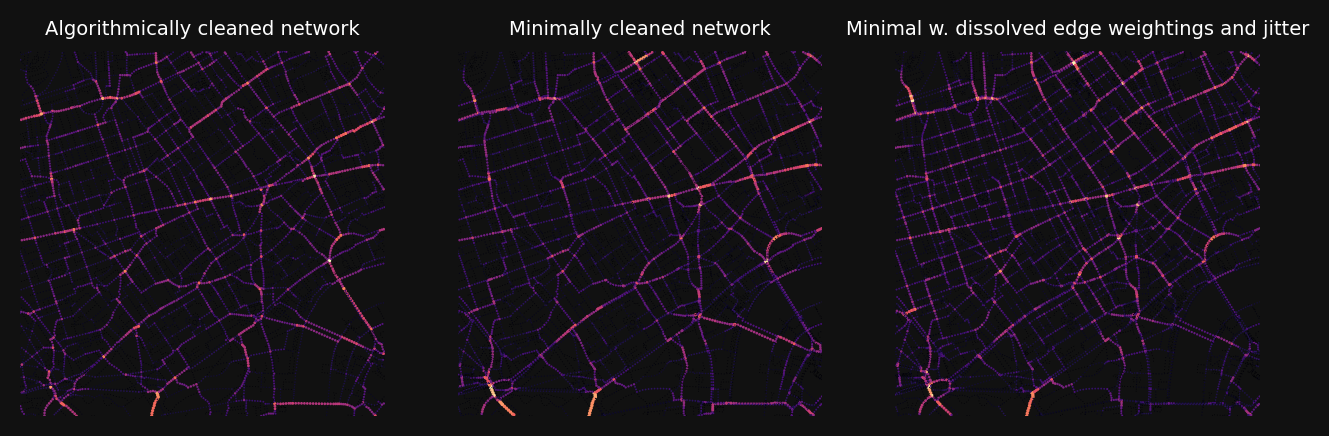

In [6]:
bg_colour = "#111"
betas = rustalgos.betas_from_distances(distances)
avg_dists = rustalgos.avg_distances_for_betas(betas)
plot_bbox = poly_utm.centroid.buffer(1500).bounds
font_size = 7
for d, b, avg_d in zip(distances, betas, avg_dists):
    print(
        f"""
    "Gravity" index (spatial impedance weighted closeness-like centrality):
    Avg walking tolerance: {avg_d:.2f}m
    Beta: {b:.3f} (spatial impedance factor)
    Max walking tolerance: {d:.1f}m
    """
    )
    fig, axes = plt.subplots(1, 3, figsize=(8, 7), dpi=200, facecolor=bg_colour)
    plot.plot_scatter(
        axes[0],
        network_structure.node_xs,
        network_structure.node_ys,
        nodes_gdf[f"cc_metric_node_beta_{d}"],
        bbox_extents=plot_bbox,
        cmap_key="magma",
        face_colour=bg_colour,
    )
    axes[0].set_title("Algorithmically cleaned network", fontsize=font_size)
    plot.plot_scatter(
        axes[1],
        network_structure_minimal.node_xs,
        network_structure_minimal.node_ys,
        nodes_gdf_minimal[f"cc_metric_node_beta_{d}"],
        bbox_extents=plot_bbox,
        cmap_key="magma",
        face_colour=bg_colour,
    )
    axes[1].set_title("Minimally cleaned network", fontsize=font_size)
    plot.plot_scatter(
        axes[2],
        network_structure_dissolved.node_xs,
        network_structure_dissolved.node_ys,
        nodes_gdf_dissolved[f"cc_metric_node_beta_{d}"],
        bbox_extents=plot_bbox,
        cmap_key="magma",
        face_colour=bg_colour,
    )
    axes[2].set_title("Minimal w. dissolved edge weightings and jitter", fontsize=font_size)
    plt.show()

for d, b, avg_d in zip(distances, betas, avg_dists):
    print(
        f"""
    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: {avg_d:.2f}m
    Beta: {b:.3f} (spatial impedance factor)
    Max walking tolerance: {d:.1f}m
    """
    )
    fig, axes = plt.subplots(1, 3, figsize=(8, 7), dpi=200, facecolor=bg_colour)
    plot.plot_scatter(
        axes[0],
        network_structure.node_xs,
        network_structure.node_ys,
        nodes_gdf[f"cc_metric_node_betweenness_{d}"],
        bbox_extents=plot_bbox,
        cmap_key="magma",
        s_max=2,
        face_colour=bg_colour,
    )
    axes[0].set_title("Algorithmically cleaned network", fontsize=font_size)
    plot.plot_scatter(
        axes[1],
        network_structure_minimal.node_xs,
        network_structure_minimal.node_ys,
        nodes_gdf_minimal[f"cc_metric_node_betweenness_{d}"],
        bbox_extents=plot_bbox,
        cmap_key="magma",
        s_max=2,
        face_colour=bg_colour,
    )
    axes[1].set_title("Minimally cleaned network", fontsize=font_size)
    plot.plot_scatter(
        axes[2],
        network_structure_dissolved.node_xs,
        network_structure_dissolved.node_ys,
        nodes_gdf_dissolved[f"cc_metric_node_betweenness_{d}"],
        bbox_extents=plot_bbox,
        cmap_key="magma",
        s_max=2,
        face_colour=bg_colour,
    )
    axes[2].set_title("Minimal w. dissolved edge weightings and jitter", fontsize=font_size)
    plt.show()